In [9]:
import pandas as pd
from textblob import TextBlob
import nltk
nltk.download('punkt')
df = pd.read_csv('C:/Users/User/Desktop/10/data/raw_analyst_ratings.csv')

df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


<span style="font-size:32px; font-weight:bold;">Obtain Basic Statistics for Textual Lengths</span>


In [10]:
df['headline_length'] = df['headline'].apply(len)

headline_length_stats = df['headline_length'].describe()

print("Headline Length Statistics:")
print(headline_length_stats)


Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


<span style="font-size:32px; font-weight:bold;">Count the Number of Articles Per Publisher</span>


In [11]:

articles_per_publisher = df['publisher'].value_counts()

print("Number of Articles Per Publisher:")
print(articles_per_publisher)


Number of Articles Per Publisher:
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: publisher, Length: 1034, dtype: int64


<span style="font-size:32px; font-weight:bold;">Analyze the Publication Dates</span>


In [13]:
print(df['date'].dtype)

object


In [17]:
print(df['date'].head())


0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object


In [18]:
df['date'] = df['date'].astype(str)


In [19]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['date'] = df['date'].dt.tz_localize(None)

In [20]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(df['date'].dtype)
print(df['date'].head())


datetime64[ns]
0   2020-06-05 14:30:54
1   2020-06-03 14:45:20
2   2020-05-26 08:30:07
3   2020-05-22 16:45:06
4   2020-05-22 15:38:59
Name: date, dtype: datetime64[ns]


In [24]:

df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

monthly_counts = df.groupby(['year', 'month']).size().reset_index(name='count')

monthly_counts['full_date'] = pd.to_datetime(monthly_counts[['year', 'month']].assign(day=1))

monthly_counts.to_csv('monthly_article_counts.csv', index=False)

print("Monthly article counts have been saved to 'monthly_article_counts.csv'.")
print(monthly_counts.head())


Monthly article counts have been saved to 'monthly_article_counts.csv'.
   year  month  count  full_date
0  2009      2      1 2009-02-01
1  2009      4      3 2009-04-01
2  2009      5     12 2009-05-01
3  2009      6     40 2009-06-01
4  2009      7     75 2009-07-01


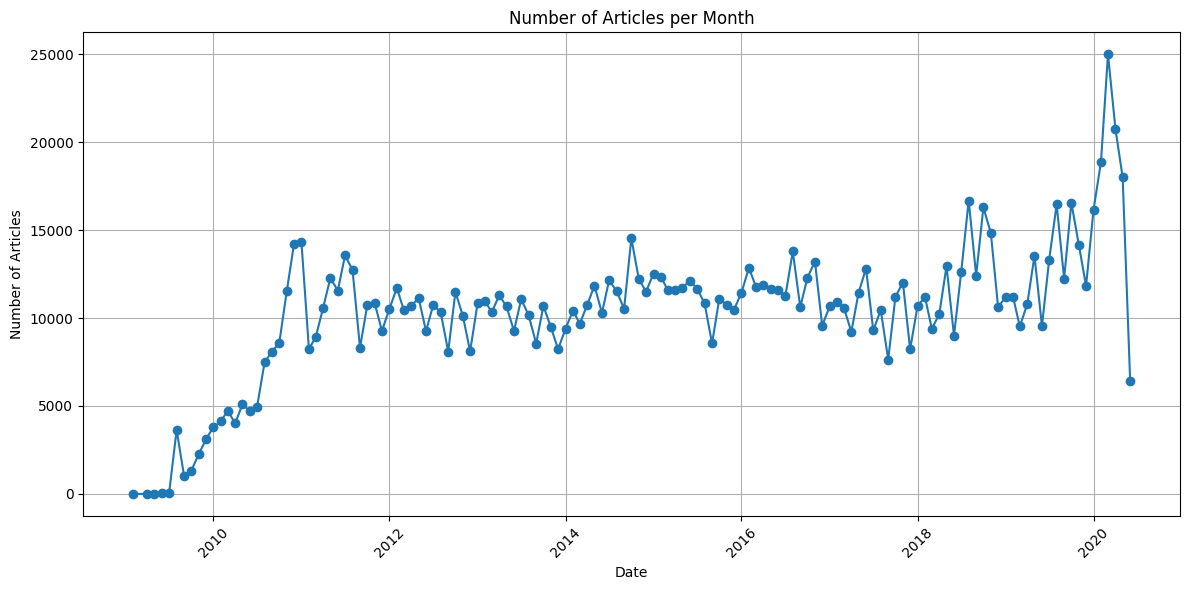

In [26]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

monthly_counts = df.groupby(['year', 'month']).size().reset_index(name='count')

monthly_counts['datetime'] = pd.to_datetime(monthly_counts[['year', 'month']].assign(day=1))

monthly_counts.to_csv('monthly_article_counts.csv', index=False)

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts['datetime'], monthly_counts['count'], marker='o', linestyle='-')
plt.title('Number of Articles per Month')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('articles_per_month.png')

plt.show()


<span style="font-size:32px; font-weight:bold;">Text Analysis(Sentiment analysis & Topic Modeling)</span>

<span style="font-size:27px; font-weight:bold;">Sentiment Analysis Using TextBlob</span>

In [27]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['headline'].apply(get_sentiment)

sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


neutral     934914
positive    341178
negative    131236
Name: sentiment, dtype: int64


<span style="font-size:27px; font-weight:bold;">Perform Topic Modeling</span>

In [93]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import spacy

nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

df['processed_headline'] = df['headline'].apply(preprocess)

texts = df['processed_headline'].tolist()
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)
